In [1]:
using Pkg; Pkg.activate()

using Plots
using Convex, ECOS  # Convex modeling and solver
using Distributions, Random  # Seeds and sampling
using LightGraphs  # Generating nice random graphs
using GraphPlot, Colors  # For plotting
using SparseArrays

OPT = () -> ECOS.Optimizer(verbose=false)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317
┌ Info: Precompiling Convex [f65535da-76fb-5f13-bab9-19810c17039a]
└ @ Base loading.jl:1317
┌ Info: Precompiling ECOS [e2685f51-7e38-5353-a97d-a921fd2c8199]
└ @ Base loading.jl:1317
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1317


#1 (generic function with 1 method)

# Generate some random data

pmax ./ ((abs.(A))' * B * gmax) = [0.03449936153421659, 0.008477329816003106, 0.0013761497559263169, 0.0024669700032737773, 0.0021331426233095183, 0.0004322956773138438, 0.0021202968213164582, 0.00143200118652898, 0.0019501688600929831, 0.0030653888988094926, 0.004653291431861824, 0.0018952816268606953, 0.0037965459461106925, 0.001063441103950665, 0.03186030138550176, 0.022728669103283326, 0.0025828558055263893, 0.004551196268641766, 0.015028505878918175, 0.019370549275520788, 0.008775712594463445, 0.000494338419080446, 0.019849166698676077, 0.015383206572091199]


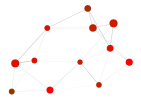

In [192]:
Random.seed!(3)
n = 12
l = 10*n

# Make graph
G = watts_strogatz(n, 4, 0.25)

# Convert to incidence matrix
A = incidence_matrix(G, oriented=true)
m = size(A, 2)

# Create generator-node mapping
node_map = vcat(collect(1:n), rand(1:n, l-n))
B = spzeros(n, l)
for (gen, node) in enumerate(node_map)
    B[node, gen] = 1
end

# Generate carbon costs
cq = zeros(l)
cl = rand(Exponential(2), l)

# Generate generation and flow capacities
gmax = rand(Gamma(4.0, 3.0), l)  # This is just to make the problem easier
pmax = rand(Beta(1.0, 100.0), m) .* (abs.(A)' * B * gmax)
@show pmax ./ (abs.(A)' * B * gmax)

# Generate demands
d = rand(Beta(3.0, 3.0), n) .* B * gmax

# Plot network
c_node = (B*cl) ./ (B*ones(l))
nodesize = maximum(d) .+ d
nodefillc = weighted_color_mean.((c_node / maximum(c_node)).^0.5, 
    colorant"red", colorant"green")
edgelinewidth = (pmax / maximum(pmax)).^0.5

Random.seed!(0)  # I put a seed here so the spring layout doesn't change
plt = gplot(G, nodesize=nodesize, nodefillc=nodefillc, edgelinewidth=edgelinewidth)

# Solve the carbon management problem

In [193]:
using Revise
using CarbonNetworks

In [194]:
cnet = PowerNetwork(cq, cl, pmax, gmax, A, B)
carbon_min = PowerManagementProblem(cnet, d)
solve!(carbon_min, OPT, verbose=true);

# Plot results

`GraphPlot` is only for making simple plots. To do more advanced things (like the plot in the carbon accounting paper), we'll need to draw the graph manually.

For now, I'm going to make some simple diagnostic plots.

## Plot demand, generation, and LMPs

Here, the LMPs are carbon LMPs.

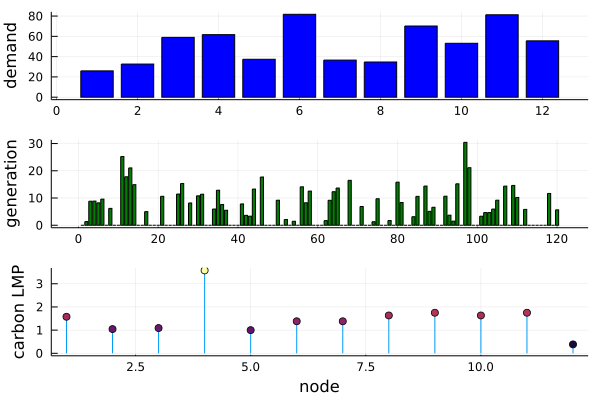

In [195]:
λ = get_lmps(carbon_min)  # <-- LMPs

# Fancy colors
gradient = cgrad(:inferno)
lmp_colors = [get(gradient, λi/maximum(λ)) for λi in λ]

plt1 = bar(d, label=nothing, c=:blue, ylabel="demand")
plt2 = bar(evaluate(carbon_min.g), label=nothing, c=:green, ylabel="generation")
plt3 = sticks(λ, label=nothing, ylabel="carbon LMP", xlabel="node")
scatter!(plt3, λ, c=lmp_colors, label=nothing)

plot(plt1, plt2, plt3, layout=(3, 1))

## Plot carbon LMPs

Brighter is more carbon intensive. At the bright nodes (orange and yellow), increasing / decreasing demand has the greatest effect on total emissions.

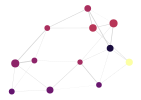

In [196]:
Random.seed!(0)  # <-- For the node layout consistency
plt = gplot(G, nodesize=nodesize, nodefillc=lmp_colors, edgelinewidth=edgelinewidth)

# Implicit diff

In [197]:
using CarbonNetworks: kkt, flatten_variables

Random.seed!(4)

fq = 3 .+ rand(Exponential(3), l)  # generate monetary costs
fl = 3 .+ rand(Exponential(3), l)

# Solve cost minimization problem
net = PowerNetwork(fq, fl, pmax, gmax, A, B)
opf = PowerManagementProblem(net, d)
solve!(opf, OPT, verbose=true)

kkt_resid = kkt(flatten_variables(opf), net, d)
@show norm(kkt_resid)

norm(kkt_resid) = 0.06677366324416124


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/degleris/.julia/packages/Convex/LMZC7/src/solution.jl:250


0.06677366324416124

In [198]:
sum(abs, evaluate(opf.p)) / sum(d)

0.06934671610786734

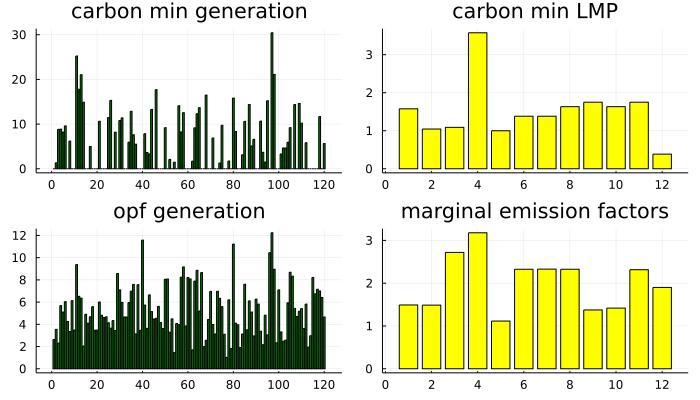

In [199]:
∇C = zeros(kkt_dims(n, m, l))
∇C[1:l] .= cl

mefs = sensitivity_demand(opf, ∇C, net, d)

theme(:default, legend=false)
plt1a = bar(evaluate(carbon_min.g), title="carbon min generation", color=:green)
plt1b = bar(get_lmps(carbon_min), title="carbon min LMP", color=:yellow)
plt2a = bar(evaluate(opf.g), title="opf generation", color=:green)
plt2b = bar(mefs, title="marginal emission factors", color=:yellow)
plot(plt1a, plt1b, plt2a, plt2b, layout=(2, 2), size=(700, 400))

# Compute MEFs via regression

In [200]:
using CarbonNetworks: solve_pmp

Random.seed!(14)

num_cases = 1000
ζ = 0.01
ϵ = 0.015

regions = rand(1:4, n)
R = zeros(n, 4)
for (node, region) in enumerate(regions)
    R[node, region] = 1
end

d_hidden = rand(Uniform(0.65, 0.85), 4)

flows = []
cases = []
for _ in 1:num_cases
    #d_hidden .*= rand(Uniform(0.99, 1.02))
    #d_hidden .*= rand(Uniform(0.96, 1.04), n)
    
    d_hidden .+= ζ*randn(4)
    
    d_obs = max.(0.5, min.(R*d_hidden + ϵ*randn(n), 1)) .* (B*gmax)
    
    g, pmp, _ = solve_pmp(fq, fl, d_obs, pmax, gmax, A, B)
    if Int(pmp.problem.status) ∉ [1, 7]
        @show pmp.problem.status
    end
    
    push!(cases, (d=d_obs, g=g, pmp=pmp))
    push!(flows, sum(abs, evaluate(pmp.p)) / sum(g))
end

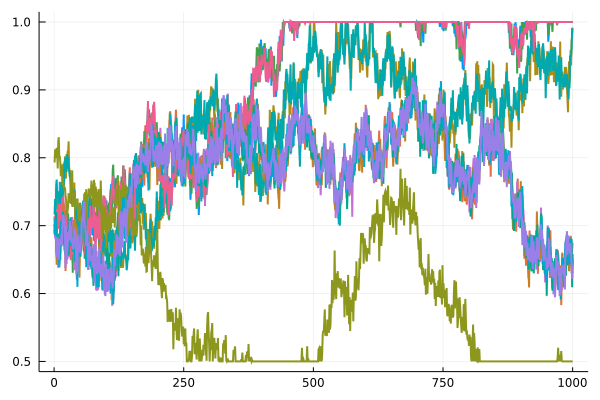

In [201]:
theme(:default, label=nothing, lw=2)
plot([d[i] / (B*gmax)[i] for (d, g) in cases, i in 1:n])

In [202]:
E = [B * (cl .* g) for (d, g) in cases]

Δd = hcat([cases[t].d - cases[t-1].d for t in 2:num_cases]...)
ΔE = hcat([E[t] - E[t-1] for t in 2:num_cases]...);

In [203]:
theme(:default, label=nothing)

plts = []
for i in 1:n
    μi = Δd[i, :] \ ΔE[i, :]
    ΔE_est = Δd[i, :] * μi
    correlation = cor(ΔE_est, ΔE[i, :])

    #@show correlation
    #@show μi

    μi_diffs = []

    for case in cases[1:100]
        params = (fq, fl, case.d, pmax, gmax, A)
        ∇C = zeros(kkt_dims(n, m, l))
        ∇C[1:l] .= cl

        mefs = sensitivity_demand(case.pmp, ∇C, net, case.d)
        push!(μi_diffs, mefs[i])
    end
    μi_diff = mean(μi_diffs)

    #@show μi_diff
    #@show i, minimum(μi_diffs), maximum(μi_diffs)
    # println()

    x_coords = Δd[i, :]
    
    label = (i > 1) ? nothing : "mean mef"
    label2 = (i > 1) ? nothing : "max mef"
    
    sim_mean = μi_diff*x_coords
    sim_max = maximum(μi_diffs)*x_coords
    sim_min = minimum(μi_diffs)*x_coords

    plt = scatter(x_coords, ΔE[i, :], xlabel="Δd", ylabel="ΔE", ms=2, title="$i")
    plot!(plt, x_coords, ΔE_est, lw=2) #, label="r2=$(round(correlation, digits=2))", legend=:topleft)
    plot!(plt, x_coords, sim_mean, lw=2, legend=:topleft, color=:Green)
    #plot!(plt, x_coords, maximum(μi_diffs)*x_coords, lw=2, color=:Cyan, ls=:dot)
    #plot!(plt, x_coords, minimum(μi_diffs)*x_coords, lw=2, color=:Cyan, ls=:dot)
    push!(plts, plt)
end

plot(plts..., layout=(3, 4), size=(900, 450))

In [ ]:
#edges_10 = findall(x -> x != 0, A[15, :])
#edges_16 = findall(x -> x != 0, A[16, :])
#@show edges_15 edges_16

#heatmap(Matrix(neighbors), c=:grays, yflip=true)
plot()
#bar(pmax)
bar!(abs.(evaluate(cases[100].pmp.p) ./ pmax), size=(700, 200))
